In [27]:
import torch
from emonet import EmoNet
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
random.seed(42)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmoNet(n_expression=8)
model.load_state_dict(torch.load("D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\\finetuned_emonet_100_epochs.pth"))
model.to(device)
model.eval()

### Preparing data for Angry Male (B and W)

In [29]:
#defining image transform
cfd_transform=transforms.Compose([ transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

In [30]:
#loading images from folders
def load_images(path):
    images_list=[]
    filenames=os.listdir(path)
    for file in filenames:
        img_path=os.path.join(path,file)
        image = Image.open(img_path).convert("RGB")  # Ensure it's in RGB mode
        image = cfd_transform(image)
        images_list.append(image)
    return torch.stack(images_list)

In [31]:
path1="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\Black\Angry"
path2="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\White\Angry"  #change accordingly

b_imglist=load_images(path1)
w_imglist=load_images(path2)

print("Black Angry Images Shape:", b_imglist.shape)
print("White Angry Images Shape:", w_imglist.shape)

#we've loaded corresponding images

Black Angry Images Shape: torch.Size([35, 3, 256, 256])
White Angry Images Shape: torch.Size([35, 3, 256, 256])


### Analyzing for conv4, last conv layer before hourglass block

In [32]:
#observing last conv_layer before hourglass block, conv_4
black_feature_maps_dict = {}
def hook_fn(module, input, output):
    black_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [33]:
#observing last conv_layer before hourglass block, conv_4
white_feature_maps_dict = {}
def hook_fn(module, input, output):
    white_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [34]:
#passing angry black male images through emonet
black_feature_maps=[]
white_feature_maps=[]

with torch.no_grad():
    for i in range(b_imglist.shape[0]):
        image = b_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        black_feature_maps.append(black_feature_maps_dict["conv4"])

In [35]:
#we reset the dictionary to ensure new feature maps are added to white dictionary
feature_maps_dict={}

with torch.no_grad():
    for i in range(w_imglist.shape[0]):
        image = w_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        white_feature_maps.append(white_feature_maps_dict["conv4"]) 

In [36]:
wfm_tensor=torch.stack(white_feature_maps)
bfm_tensor=torch.stack(black_feature_maps)

In [37]:
wfm_tensor.shape

torch.Size([35, 1, 256, 64, 64])

In [38]:
black_mean_activation = bfm_tensor.mean(dim=0) 
white_mean_activation = wfm_tensor.mean(dim=0) 

activation_difference = torch.abs(black_mean_activation - white_mean_activation)

#averaging activations of feature maps for all images of black and white, and taking their absolute difference.

print("Black Mean Activation Shape:", black_mean_activation.shape)
print("White Mean Activation Shape:", white_mean_activation.shape)
print("Activation Difference Shape:", activation_difference.shape)

Black Mean Activation Shape: torch.Size([1, 256, 64, 64])
White Mean Activation Shape: torch.Size([1, 256, 64, 64])
Activation Difference Shape: torch.Size([1, 256, 64, 64])


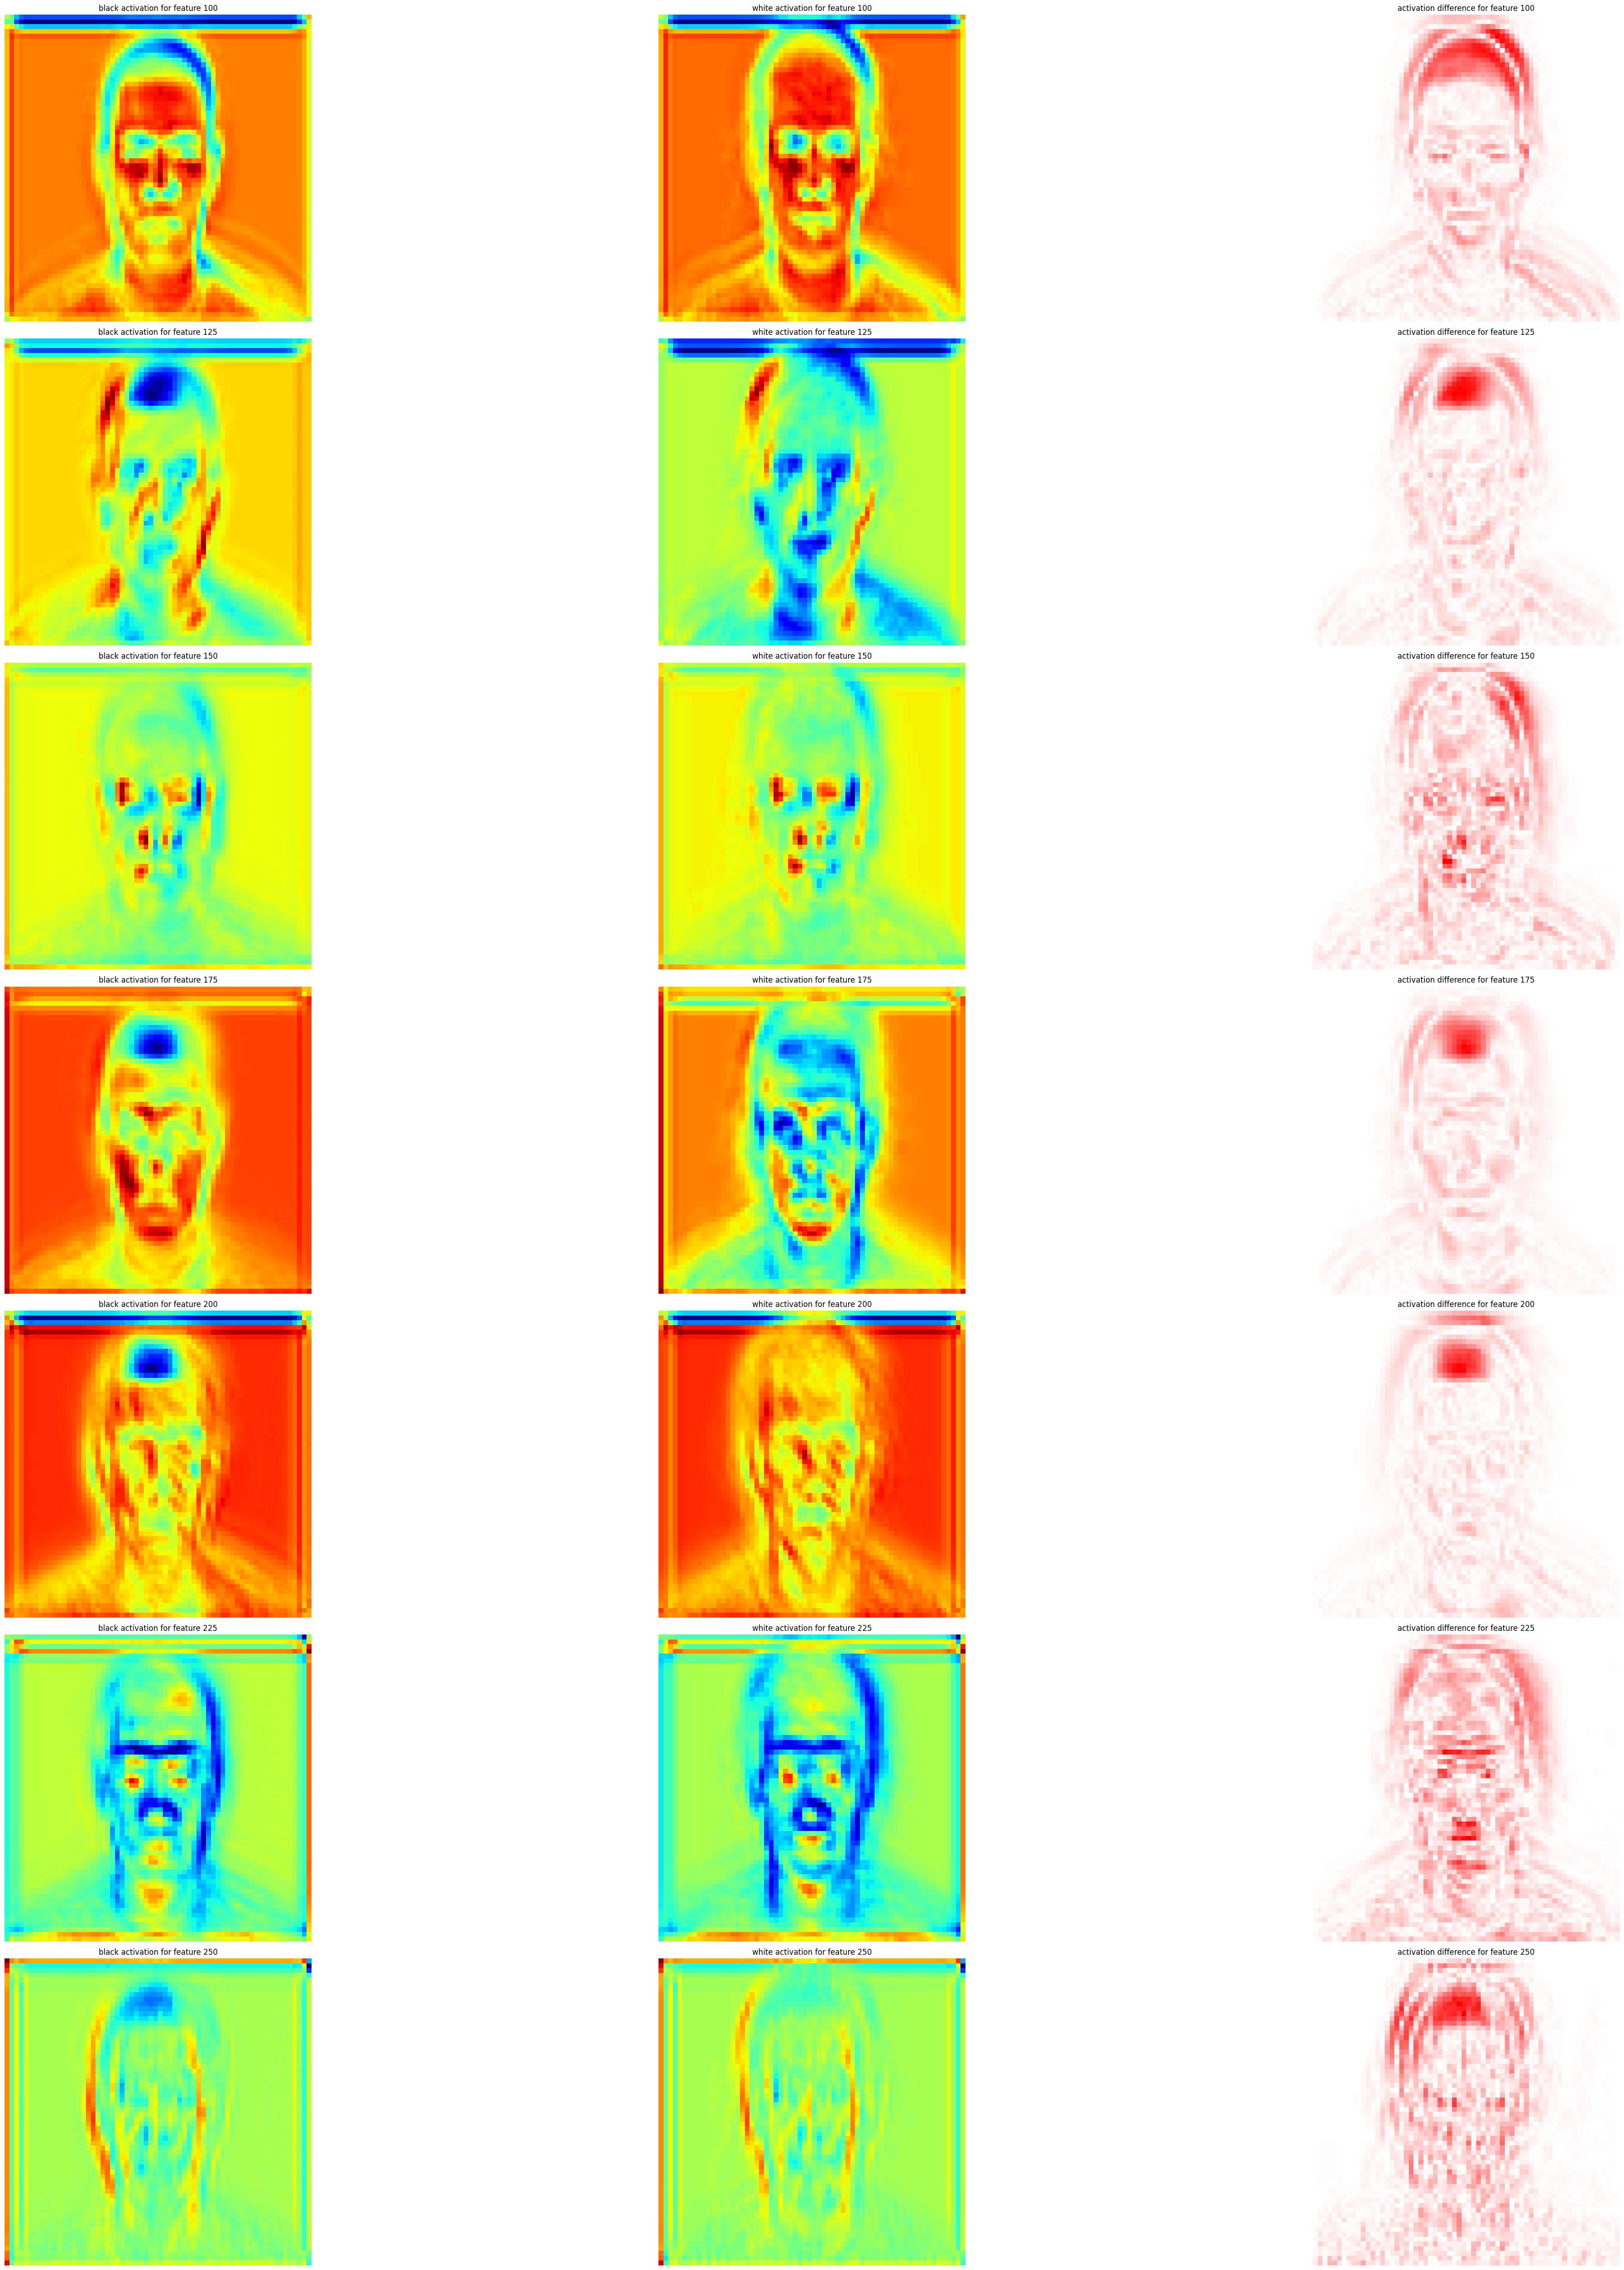

In [39]:
black_mean_activation = black_mean_activation.squeeze(0).cpu().detach().numpy()  
white_mean_activation = white_mean_activation.squeeze(0).cpu().detach().numpy()  
activation_difference = activation_difference.squeeze(0).cpu().detach().numpy()  

feature_map_index = [i for i in range(100,255,25)]
fig, axes = plt.subplots(len(feature_map_index), 3, figsize=(50, 50))

for i, index in enumerate(feature_map_index):
    black_activation_map = black_mean_activation[index]
    white_activation_map = white_mean_activation[index]
    difference_map = activation_difference[index]

    axes[i, 0].imshow(black_activation_map, cmap='jet')
    axes[i, 0].set_title(f"black activation for feature {index}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(white_activation_map, cmap='jet')
    axes[i, 1].set_title(f"white activation for feature {index}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(difference_map, cmap='bwr', vmin=-np.max(np.abs(difference_map)), vmax=np.max(np.abs(difference_map)))
    axes[i, 2].set_title(f"activation difference for feature {index}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
